## ライブラリのインポート

In [1415]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## データの読み込み

In [1416]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
df = pd.concat([train, test], axis=0, ignore_index=True)
# train.head()

## 前処理

In [1417]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = pd.to_datetime(df['datetime']).dt.strftime('%Y')
df['month'] = pd.to_datetime(df['datetime']).dt.strftime('%m')
df['day'] = pd.to_datetime(df['datetime']).dt.strftime('%d')
df['weekday'] = pd.to_datetime(df['datetime']).dt.strftime('%a')
df['hour'] = pd.to_datetime(df['datetime']).dt.strftime('%H')

df = df.sort_values('datetime')
# df['moving_ave_7'] = df['count'].rolling(window= 7, center=True).mean() # 7日間移動平均
df['moving_ave_14'] = df['count'].rolling(window=14, center=True).mean() #14日間移動平均
# df.dropna(inplace=True)

df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'weekday', 'hour', 'moving_ave_14'],
      dtype='object')

In [1418]:
# df.iloc[400:450,:]

## カラムの選択

In [1419]:
df = df[
    [
        # 'datetime',
        'temp',    
        # 'humidity',
        # 'windspeed',
        'holiday',
        'workingday',
        'weather',
        # 'month',
        'weekday',
        'hour',
        'count',
        # 'moving_ave_7',
        # 'moving_ave_14',
    ]
]

In [1420]:
df = pd.get_dummies(df, columns=[
    # 'month',
    'weekday',
    'hour',
    'weather',
])

In [1421]:
# # 対数変換
# df['count'] = np.log(df['count']+1)

## 学習データの準備

In [1422]:
df.columns

Index(['temp', 'holiday', 'workingday', 'count', 'weekday_Fri', 'weekday_Mon',
       'weekday_Sat', 'weekday_Sun', 'weekday_Thu', 'weekday_Tue',
       'weekday_Wed', 'hour_00', 'hour_01', 'hour_02', 'hour_03', 'hour_04',
       'hour_05', 'hour_06', 'hour_07', 'hour_08', 'hour_09', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'weather_1', 'weather_2', 'weather_3', 'weather_4'],
      dtype='object')

In [1423]:
df = df.sort_index()

In [1424]:
train = df.iloc[:len(train),:].copy()
train['count'] = train['count'].astype('int64')

In [1425]:
test = df.iloc[len(train):,:].copy()
test.drop(['count'], axis=1, inplace=True)
test = test.reset_index(drop=True)

In [1426]:
y = train.loc[:,["count"]].values
train.drop(['count'], axis=1, inplace=True)
X = train.values

In [1427]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
y_train = y_train.ravel()   # 1    2d array -> 1d array 
y_test  = y_test.ravel()    # 2    2d array -> 1d array 

## モデル構築

In [1428]:
# データセットを生成する
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# LightGBM のハイパーパラメータ
params = {
    'boosting_type': 'gbdt',
    'task': 'train',
    'objective': 'regression',
    
    'learning_rate': 0.1,
    'early_stopping_round': 20,
    'verbose': -1,
    'random_state': 0,
    
    'max_depth': 7,
    'num_leaves': int(0.7*2**8),
    'num_iterations': 1000,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.9,
}
# num_iterationsはearlystoppingするから気にしなくていい
#　max_depthは3〜8くらい。7くらいが無難
# num_leaves 最重要。複雑さに直結。max_depthの自乗よりは大きくならない

# 上記のパラメータでモデルを学習する
model = lgb.train(params, lgb_train, valid_sets=lgb_eval)

# テストデータを予測する
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print(y_pred.max())
y_pred

/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's l2: 29574.5
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 27199.2
[3]	valid_0's l2: 25382.1
[4]	valid_0's l2: 23312.5
[5]	valid_0's l2: 21623.8
[6]	valid_0's l2: 20234
[7]	valid_0's l2: 19120.8
[8]	valid_0's l2: 18076
[9]	valid_0's l2: 17179.7
[10]	valid_0's l2: 16355.6
[11]	valid_0's l2: 15667.2
[12]	valid_0's l2: 15064.6
[13]	valid_0's l2: 14472.7
[14]	valid_0's l2: 14010.9
[15]	valid_0's l2: 13496.7
[16]	valid_0's l2: 13111.1
[17]	valid_0's l2: 12734.9
[18]	valid_0's l2: 12357.6
[19]	valid_0's l2: 12053.6
[20]	valid_0's l2: 11791.3
[21]	valid_0's l2: 11574.7
[22]	valid_0's l2: 11235.3
[23]	valid_0's l2: 10976.3
[24]	valid_0's l2: 10780.1
[25]	valid_0's l2: 10597.1
[26]	valid_0's l2: 10437.9
[27]	valid_0's l2: 10292.6
[28]	valid_0's l2: 10014.8
[29]	valid_0's l2: 9890.16
[30]	valid_0's l2: 9664.83
[31]	valid_0's l2: 9563.3
[32]	valid_0's l2: 9475.42
[33]	valid_0's l2: 9371.91
[34]	valid_0's l2: 9162.91
[35]	valid_0's l2: 8974.52
[36]	val

array([252.4443406 , 344.53227983, 296.56727543, ..., 473.74244025,
       356.74167542,  60.18089184])

In [1429]:
# model = lgb.LGBMRegressor(random_state=0)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

In [1430]:
# スコアを表示。小さいほどよい
def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: #check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

In [1431]:
# from sklearn.linear_model import Lasso                         # LASSO回帰のクラスを読み込み
# model = Lasso(alpha=1)                                # LASSO回帰のインスタンスを生成
# model = model_lasso.fit(X_train, y_train)                                      # データを学習させる
# y_pred = model.predict(X_test)

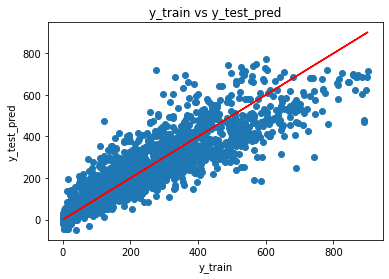

In [1432]:
# 散布図を描画(真値 vs 予測値)
plt.plot(y_test, y_test, color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
plt.scatter(y_test, y_pred) # 散布図のプロット
plt.xlabel('y_train') # x軸ラベル
plt.ylabel('y_test_pred') # y軸ラベル
plt.title('y_train vs y_test_pred') # グラフタイトル
plt.show()

In [1433]:
print("test score: ",rmsle(y_test, model.predict(X_test)))
print("train score: ",rmsle(y_train, model.predict(X_train)))

test score:  0.5063262019689356
train score:  0.48908003554262924


In [1434]:
# y_t = pd.DataFrame(model.predict(X_train))
# y_t.describe()

In [1435]:
test_pred = model.predict(test)
test_pred = pd.DataFrame(test_pred, columns=['count'])
# test_pred['count'] = np.exp(test_pred['count']) - 1
test_pred['count'] = test_pred['count'].astype('int64')

submission  = pd.read_csv('input/sampleSubmission.csv')
submission = pd.DataFrame(submission['datetime'])
submission = pd.concat([submission, test_pred], axis=1)

# submission['count'].sum()/submission['count'].count()

In [1436]:
y_p = pd.DataFrame(model.predict(X_test))
y_p.describe()

,0
count,2722.000000
mean,191.686357
std,164.124323
min,-49.971486
25%,50.792962
50%,166.861299
75%,277.966763
max,772.244008


In [1437]:
display(submission.describe())
print(y_p.loc[y_p[0]<0].count())
print(submission.loc[submission['count']<0, 'count'].count())

,count
count,6493.000000
mean,191.398121
std,164.988002
min,-43.000000
25%,50.000000
50%,162.000000
75%,276.000000
max,771.000000


0    118
dtype: int64
187


In [1438]:
submission.loc[submission['count']<0, 'count'] = 0

In [1439]:
submission.to_csv('output/submission.csv',index=False)